In [0]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("TimeSeriesAnalysis").getOrCreate()

# Load the dataset from Databricks Delta table location
file_path = "dbfs:/user/hive/warehouse/delta_training.db/daily_minimum"
df = spark.read.format('delta').load(file_path)

# Show the first few rows of the dataset
df.show(5)


+----------+--------------------------+
|      Date|Daily minimum temperatures|
+----------+--------------------------+
|1981-01-01|                      20.7|
|1981-01-02|                      17.9|
|1981-01-03|                      18.8|
|1981-01-04|                      14.6|
|1981-01-05|                      15.8|
+----------+--------------------------+
only showing top 5 rows



In [0]:
from pyspark.sql.functions import to_date, col

# Convert the timestamp column to a date format
df = df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))

# Drop rows with missing values
df = df.dropna()

# Sort data by date
df = df.orderBy("Date")

# Display the cleaned data
df.show(5)


+----------+--------------------------+
|      Date|Daily minimum temperatures|
+----------+--------------------------+
|1981-01-01|                      20.7|
|1981-01-02|                      17.9|
|1981-01-03|                      18.8|
|1981-01-04|                      14.6|
|1981-01-05|                      15.8|
+----------+--------------------------+
only showing top 5 rows



In [0]:
from pyspark.sql.functions import year, month, avg, col

# Extract year and month
df = df.withColumn("Year", year(col("Date"))).withColumn("Month", month(col("Date")))

# Calculate monthly average temperature using the correct column name
monthly_trends = df.groupBy("Year", "Month").agg(avg(col("Daily minimum temperatures")).alias("Average_Temp"))
monthly_trends.show(10)


+----+-----+------------------+
|Year|Month|      Average_Temp|
+----+-----+------------------+
|1990|    7| 8.183870967741935|
|1987|   10|10.238709677419354|
|1986|    1|13.825806451612904|
|1983|    3|15.777419354838708|
|1984|   12|12.643333333333334|
|1983|    4|10.596666666666668|
|1985|    3|15.877419354838711|
|1990|    4|13.433333333333332|
|1990|    6| 7.719999999999999|
|1984|   10|10.632258064516131|
+----+-----+------------------+
only showing top 10 rows



In [0]:
from pyspark.sql.functions import avg, col

# Aggregate by month to find seasonal trends using the correct column name
seasonality = df.groupBy("Month").agg(avg(col("Daily minimum temperatures")).alias("Average_Temp"))
seasonality.show()


+-----+------------------+
|Month|      Average_Temp|
+-----+------------------+
|   12|13.851948051948042|
|    1|15.030322580645171|
|    6| 7.278333333333333|
|    3|14.565483870967752|
|    5| 9.866451612903221|
|    9|  8.97633333333334|
|    4| 12.08833333333333|
|    8| 7.891290322580645|
|    7| 6.754397394136806|
|   10|10.309354838709684|
|   11|12.479666666666665|
|    2|15.373758865248226|
+-----+------------------+



In [0]:
from pyspark.sql.functions import mean, stddev, col

# Calculate mean and standard deviation for 'Daily minimum temperatures'
stats = df.select(mean("Daily minimum temperatures").alias("mean"), stddev("Daily minimum temperatures").alias("stddev")).collect()
mean_val, stddev_val = stats[0]["mean"], stats[0]["stddev"]

# Add a Z-score column
df = df.withColumn("Z_score", (col("Daily minimum temperatures") - mean_val) / stddev_val)

# Filter anomalies (e.g., Z-score > 3 or < -3)
anomalies = df.filter((col("Z_score") > 3) | (col("Z_score") < -3))
anomalies.show()


+----------+--------------------------+----+-----+------------------+
|      Date|Daily minimum temperatures|Year|Month|           Z_score|
+----------+--------------------------+----+-----+------------------+
|1981-01-15|                        25|1981|    1| 3.400904267096705|
|1981-01-18|                      24.8|1981|    1| 3.351663446877671|
|1981-02-09|                        25|1981|    2| 3.400904267096705|
|1982-01-17|                        24|1982|    1|3.1547001660015352|
|1982-01-20|                      25.2|1982|    1|3.4501450873157387|
|1982-02-15|                      26.3|1982|    2| 3.720969598520426|
|1984-11-26|                      24.3|1984|   11|3.2285613963300865|
|1987-11-19|                      24.1|1987|   11| 3.179320576111053|
|1988-01-30|                      23.4|1988|    1| 3.006977705344433|
|1988-12-16|                      23.9|1988|   12| 3.130079755892018|
+----------+--------------------------+----+-----+------------------+



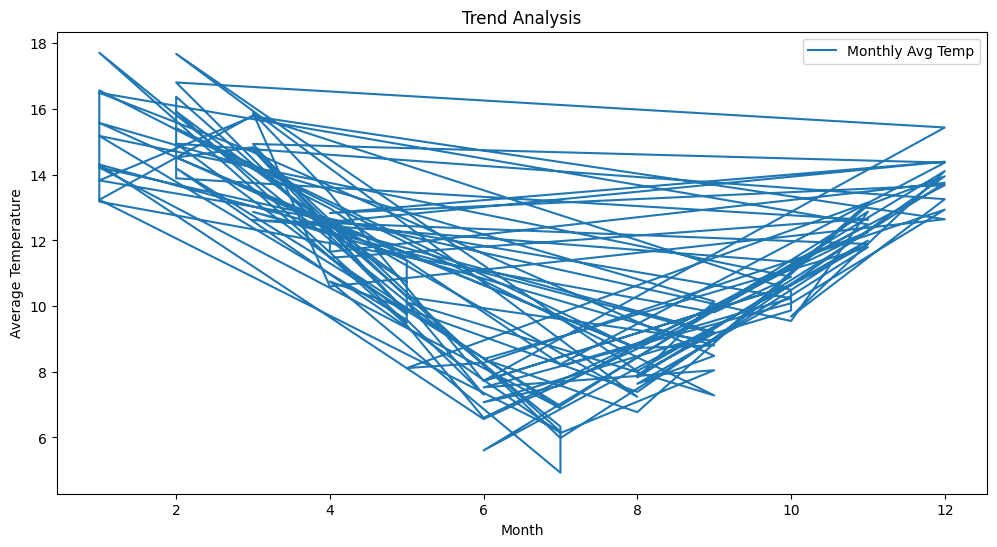

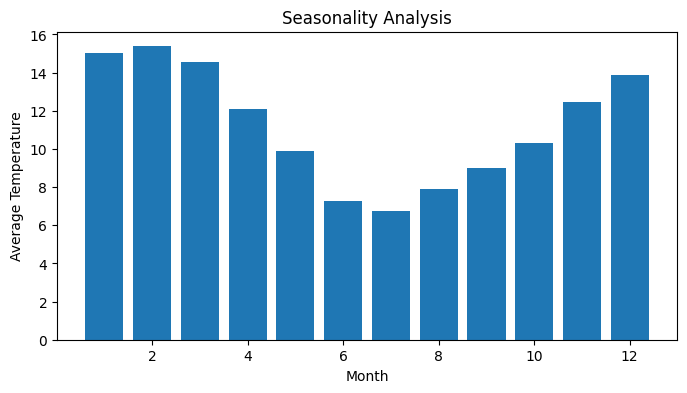

Index(['Date', 'Daily minimum temperatures', 'Year', 'Month', 'Z_score'], dtype='object')


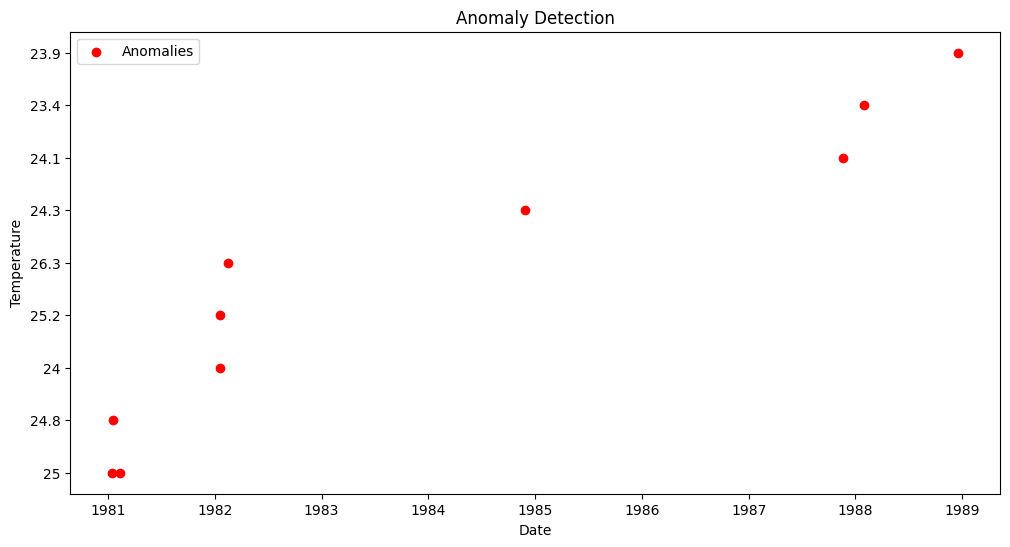

In [0]:
# Convert Spark DataFrames to Pandas for visualization
pandas_trends = monthly_trends.toPandas()
pandas_seasonality = seasonality.toPandas()
pandas_anomalies = anomalies.toPandas()

import matplotlib.pyplot as plt

# Plot trends
plt.figure(figsize=(12, 6))
plt.plot(pandas_trends["Month"], pandas_trends["Average_Temp"], label="Monthly Avg Temp")
plt.title("Trend Analysis")
plt.xlabel("Month")
plt.ylabel("Average Temperature")
plt.legend()
plt.show()

# Plot seasonality
plt.figure(figsize=(8, 4))
plt.bar(pandas_seasonality["Month"], pandas_seasonality["Average_Temp"])
plt.title("Seasonality Analysis")
plt.xlabel("Month")
plt.ylabel("Average Temperature")
plt.show()

# Highlight anomalies
# Check column names to ensure correct one is used
print(pandas_anomalies.columns)

# Assuming 'Date' and 'Daily minimum temperatures' are the correct columns
plt.figure(figsize=(12, 6))
plt.scatter(pandas_anomalies["Date"], pandas_anomalies["Daily minimum temperatures"], color="red", label="Anomalies")
plt.title("Anomaly Detection")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.show()
